- http://keunwoochoi.blogspot.com/2016/03/2.html
- http://www.rex-ai.info/docs/AI_Example_CNN_speech_recognize
- https://www.youtube.com/watch?v=oltGIc4uo5c
- https://youdaeng-com.tistory.com/5
- https://quokkas.tistory.com/37 : early stopping
- https://continuous-development.tistory.com/166 : stratified kfold
- https://deep-learning-study.tistory.com/476 fiter 시각화
- https://wyatt37.tistory.com/10 : random over sampling

In [1]:
import wandb

wandb.init(project="SVD-voice-disorder", entity="bub3690",settings=wandb.Settings(_disable_stats=True))
#wandb.run.name = 'TGRAM-organics-speaker-egg'
#wandb.run.name = 'resnet-organics-speaker-egg'
wandb.run.name = 'resnet-organics-speaker-fusion'
wandb.run.save()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: bub3690. Use `wandb login --relogin` to force relogin


wandb: WARNING Calling wandb.run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


True

In [2]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn # 인공 신경망 모델들 모아놓은 모듈
import torch.nn.functional as F #그중 자주 쓰이는것들을 F로
from torchvision import transforms, datasets
import cv2
from torchvision import transforms, datasets
import pandas as pd
import os
from glob import glob
import torchvision.models as models
import sys

from Utils.pytorchtools import EarlyStopping # 상위 폴더에 추가된 모듈.


if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
#DEVICE = torch.device('cpu')
print('Using Pytorch version : ',torch.__version__,' Device : ',DEVICE)

Using Pytorch version :  1.10.2  Device :  cuda


In [3]:
import torchaudio
#import torchaudio.functional as F
import torchaudio.transforms as T

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(1234)

# SVD 문장 데이터에서 Feature 추출
- mfcc

In [4]:
import numpy as np
import librosa, librosa.display 
import matplotlib.pyplot as plt
#window sizde : FFT를 할때 참조할 그래프 길이 ( 프레임 하나당 sample 수 )
#자연어 처리에서는 25ms 사용. https://ahnjg.tistory.com/93
#초당 50000hz 중 1250개씩 윈도우 사이즈로 사용.


#default param
mfcc_run_config = dict(
    sr=16000,
    n_mfcc=27,
    #dct_type=3, # type2 default
    lifter = 35,

    
    #mel spectro
    n_mels=170,
    hop_length=750,
    n_fft =14056,    
    win_length=1100,
    f_max=8000,
    
    # training
    #batch_size=32,
    mel_scale ='htk',
    
    # data
    fold=1,
)

mel_run_config = dict(
    sr=16000,
    n_mels=128,
    win_length =  300,
    n_fft= 2048,
    hop_length= 50,
    f_max = 8000    
)


spectro_run_config =dict(
    sr=16000,
    n_fft=350,
    hop_length=50,
    win_length=350,
    # training
    batch_size=16,
)




#또는 10ms만큼으로 한다고 한다.
#hop_length가 mfcc의 frame수를 결정한다.

# 데이터 나누기 - Stratified KFold

- pathology : 1194 / healthy : 634 / 총 1828
- k = 5

In [5]:
speaker_data=pd.read_excel("../../voice_data/only_organics_healthy_available_ver2.xlsx")

In [6]:
pathology = speaker_data[speaker_data['PATHOLOGY']=='p']['SPEAKER'].unique().tolist()
healthy = speaker_data[speaker_data['PATHOLOGY']=='n']['SPEAKER'].unique().tolist()
print(len(pathology))
print(len(healthy))

426
630


In [7]:
list(set(healthy) & set(pathology))

[74, 1524, 142]

In [8]:
#겹치는 speaker는 곱하기 100을 해준다.
#겹치는 speaker는 그대로 둔다.

changed_patients = list(set(healthy) & set(pathology))

for patient in changed_patients:
    temp=pathology[pathology.index(patient)]*100
    pathology[pathology.index(patient)] = temp
    

In [9]:
pathology[pathology.index(152400)]

152400

In [10]:
#train test 나누기

import os
from glob import glob
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
from sklearn.model_selection import train_test_split # train , test 분리에 사용.


random_state = 1004 # 1004,1005,1006,1007,1008

X = pathology+healthy # path 데이터 합
print("총 데이터수 : ",len(X))
Y = [] # 라벨
for idx,x in enumerate(X):
    if idx<426:
        Y.append("pathology")
    else:
        Y.append("healthy")

X, X_test, Y, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=True, stratify=Y, random_state=random_state) #456
#stratify를 넣어서, test에도 라벨별 잘 분류되게 한다.

print("---")
print("훈련 셋 : ",len(Y),Counter(Y))
print("테스트 셋 : ",len(Y_test),Counter(Y_test))
print("---")



총 데이터수 :  1056
---
훈련 셋 :  844 Counter({'healthy': 504, 'pathology': 340})
테스트 셋 :  212 Counter({'healthy': 126, 'pathology': 86})
---


In [11]:
Y[169]

'healthy'

In [12]:
X.index(7400)

193

## 2. stratified k-fold

In [13]:
#1. train, test 나누기
#stratified kfold
import os
import random #데이터 shuffle 사용
from glob import glob
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import RandomOverSampler
from collections import Counter



skf_iris = StratifiedKFold(n_splits=5,shuffle=True,random_state=456)
cnt_iter = 0

X_train_list = [] #데이터 셋 보관
Y_train_list = []

X_valid_list = []
Y_valid_list = []

for train_idx, test_idx in skf_iris.split(X,Y):
    
    #split으로 반환된 인덱스를 이용하여, 학습 검증용 테스트 데이터 추출
    cnt_iter += 1
    X_train, X_valid = [X[idx] for idx in train_idx.tolist() ], [X[idx] for idx in test_idx.tolist() ]
    Y_train, Y_valid = [Y[idx] for idx in train_idx.tolist() ], [Y[idx] for idx in test_idx.tolist() ]
    
    X_train_list.append(X_train)
    X_valid_list.append(X_valid)
    
    Y_train_list.append(Y_train)
    Y_valid_list.append(Y_valid)
    
    
    #학습 및 예측
    
    label_train = Y_train
    label_test = Y_valid
    unique_train, train_counts = np.unique(label_train, return_counts = True)
    unique_test, test_counts = np.unique(label_test, return_counts = True)
    
    uniq_cnt_train = dict(zip(unique_train, train_counts))
    uniq_cnt_test = dict(zip(unique_test, test_counts))
    
    
    
    print('교차 검증 : {}'.format(cnt_iter))
    print('학습 레이블 데이터 분포 : \n', uniq_cnt_train)
    print('검증 레이블 데이터 분포 : \n', uniq_cnt_test,'\n')



교차 검증 : 1
학습 레이블 데이터 분포 : 
 {'healthy': 403, 'pathology': 272}
검증 레이블 데이터 분포 : 
 {'healthy': 101, 'pathology': 68} 

교차 검증 : 2
학습 레이블 데이터 분포 : 
 {'healthy': 403, 'pathology': 272}
검증 레이블 데이터 분포 : 
 {'healthy': 101, 'pathology': 68} 

교차 검증 : 3
학습 레이블 데이터 분포 : 
 {'healthy': 403, 'pathology': 272}
검증 레이블 데이터 분포 : 
 {'healthy': 101, 'pathology': 68} 

교차 검증 : 4
학습 레이블 데이터 분포 : 
 {'healthy': 403, 'pathology': 272}
검증 레이블 데이터 분포 : 
 {'healthy': 101, 'pathology': 68} 

교차 검증 : 5
학습 레이블 데이터 분포 : 
 {'healthy': 404, 'pathology': 272}
검증 레이블 데이터 분포 : 
 {'healthy': 100, 'pathology': 68} 



# speaker to voice

In [14]:
# speaker to voice

label_changer = dict({"healthy":"n","pathology":"p"})


all_train_record_list = []
all_valid_record_list = []
all_test_record_list = []

all_train_label_list = []
all_valid_label_list = []
all_test_label_list = []

print("train. speaker to voice")
#train
for fold_idx,fold in enumerate(X_train_list):
    fold_record=[]
    fold_y_record=[]
    for idx,speaker in enumerate(fold):
        record_list = speaker_data[ (speaker_data['SPEAKER']==speaker) & (speaker_data['PATHOLOGY']==label_changer[Y_train_list[fold_idx][idx]])]['RECORDING'].tolist()
        if record_list == []:
            # speaker가 healthy, pathology 모두 있는 경우
            print(speaker)
            speaker = speaker // 100
            record_list = speaker_data[(speaker_data['SPEAKER']==speaker) & (speaker_data['PATHOLOGY']==label_changer[Y_train_list[fold_idx][idx]] ) ]['RECORDING'].tolist()
            print(record_list)

        label_list = [ Y_train_list[fold_idx][idx] ] * len(record_list)       
        fold_record += record_list
        fold_y_record += label_list
    all_train_record_list.append(fold_record)
    all_train_label_list.append(fold_y_record)

print("valid. speaker to voice")
#valid
for fold_idx,fold in enumerate(X_valid_list):
    fold_record=[]
    fold_y_record=[]
    for idx,speaker in enumerate(fold):
        record_list = speaker_data[ (speaker_data['SPEAKER']==speaker) & (speaker_data['PATHOLOGY']==label_changer[Y_valid_list[fold_idx][idx]]) ]['RECORDING'].tolist()
        if record_list == []:
            # speaker가 healthy, pathology 모두 있는 경우
            print(speaker)
            speaker = speaker // 100
            record_list = speaker_data[(speaker_data['SPEAKER']==speaker) & (speaker_data['PATHOLOGY']==label_changer[Y_valid_list[fold_idx][idx]] ) ]['RECORDING'].tolist()
            print(record_list)
        label_list = [ Y_valid_list[fold_idx][idx] ] * len(record_list)
        
        fold_record += record_list
        fold_y_record += label_list
    all_valid_record_list.append(fold_record)
    all_valid_label_list.append(fold_y_record)

print("test. speaker to voice")
#test
fold_record=[]
fold_y_record=[]
for idx,speaker in enumerate(X_test):
    record_list = speaker_data[(speaker_data['SPEAKER']==speaker) & (speaker_data['PATHOLOGY']==label_changer[Y_test[idx]] )]['RECORDING'].tolist()
    if record_list == []:
        # speaker가 healthy, pathology 모두 있는 경우
        print(speaker)
        speaker = speaker // 100
        record_list = speaker_data[(speaker_data['SPEAKER']==speaker) & (speaker_data['PATHOLOGY']==label_changer[Y_test[idx]] ) ]['RECORDING'].tolist()
        print(record_list)
    label_list = [ Y_test[idx] ] * len(record_list)
    fold_record += record_list
    fold_y_record += label_list
all_test_record_list = fold_record
all_test_label_list = fold_y_record


X_train_list = all_train_record_list
X_valid_list = all_valid_record_list
X_test = all_test_record_list

Y_train_list = all_train_label_list
Y_valid_list = all_valid_label_list
Y_test = all_test_label_list



train. speaker to voice
152400
[932]
7400
[929]
152400
[932]
7400
[929]
152400
[932]
7400
[929]
7400
[929]
152400
[932]
valid. speaker to voice
7400
[929]
152400
[932]
test. speaker to voice
14200
[495]


## 3. random over sampling

In [15]:
#2. random over sampling
for i in range(5):
    X_temp = np.array(X_train_list[i]).reshape(-1,1)#각 데이터를 다 행으로 넣음. (1194,1)
    #Y = np.array(Y)
    ros = RandomOverSampler(random_state = 123)
    X_res,Y_res = ros.fit_resample(X_temp,Y_train_list[i])
    
    print("\n fold{} ".format(i))
    print('before dataset shape {}'.format(Counter(Y_train_list[i])) )
    print('Resampled dataset shape {}'.format(Counter(Y_res)) )   
    
    #원래대로 돌리기
    X_res=X_res.reshape(1, -1)
    X_train_list[i]=X_res[0].tolist()
    Y_train_list[i]=Y_res





 fold0 
before dataset shape Counter({'healthy': 406, 'pathology': 364})
Resampled dataset shape Counter({'healthy': 406, 'pathology': 406})

 fold1 
before dataset shape Counter({'healthy': 407, 'pathology': 402})
Resampled dataset shape Counter({'healthy': 407, 'pathology': 407})

 fold2 
before dataset shape Counter({'healthy': 407, 'pathology': 384})
Resampled dataset shape Counter({'healthy': 407, 'pathology': 407})

 fold3 
before dataset shape Counter({'healthy': 407, 'pathology': 396})
Resampled dataset shape Counter({'healthy': 407, 'pathology': 407})

 fold4 
before dataset shape Counter({'healthy': 405, 'pathology': 394})
Resampled dataset shape Counter({'pathology': 405, 'healthy': 405})


In [16]:
import pickle


    
#load
with open("../../voice_data/organics_ver2/phrase_dict_ver2.pickle","rb") as fr:
    phrase_dict = pickle.load(fr)

#with open("../../voice_data/organics/phrase_minmax_scaler_hyper.pickle","rb") as fr:
#    phrase_scaler = pickle.load(fr)
    

In [17]:
import pickle


    
#load
with open("../../voice_data/organics_ver2/phrase_dict_ver2_EGG.pickle","rb") as fr:
    phrase_egg_dict = pickle.load(fr)

#with open("../../voice_data/organics/phrase_minmax_scaler_hyper.pickle","rb") as fr:
#    phrase_scaler = pickle.load(fr)
    

# 데이터 정의
- 추가적으로 데이터의 크기를 맞춰주기 위해 3초로 padding 및 truncate 실시 https://sequencedata.tistory.com/25 FixAudioLength
- 논문에서는 400frame으로 설정.(여기서는 500frame)
- 전처리 방법 결정.


In [ ]:
# 데이터 로더

In [18]:
#default param
mfcc_run_config = dict(
    sr=16000,
    n_mfcc=27,
    #dct_type=3, # type2 default
    lifter = 35,

    
    #mel spectro
    n_mels=170,
    hop_length=750,
    n_fft =14056,    
    win_length=1100,
    f_max=8000,
    
    # training
    #batch_size=32,
    mel_scale ='htk',
    
    # data
    fold=1,
)

mel_run_config = dict(
    sr=16000,
    n_mels=128,
    win_length =  300,
    n_fft= 2048,
    hop_length= 50,
    f_max = 8000    
)


spectro_run_config =dict(
    sr=16000,
    n_fft=350,
    hop_length=50,
    win_length=350,
    # training
    batch_size=16,
)




In [19]:
from torch.utils.data import Dataset, DataLoader

classes = ["healthy","pathology"]


class svd_dataset(Dataset):
    def __init__(self,data_path_list,classes,data_num,training,mfcc_params,mel_params,spectro_params,transform=None,normalize=None,mfcc_normalize=None):
        #클래스에서 사용할 인자를 받아 인스턴스 변수로 저장하는 일을 한다.
        #예를들면, 이미지의 경로 리스트를 저장하는 일을 하게 된다.
        
        #data_num : k 개 데이터 셋 중 어떤것을 쓸지
        #test인지 아닌지.
        
        self.path_list = data_path_list[data_num]
        self.data_num = data_num
        self.training = training
        self.label = svd_dataset.get_label(self.path_list,training,data_num)
        self.classes=classes
        self.transform=transform
        self.normalize=normalize
        self.mfcc_normalize = mfcc_normalize
        # sweep params
        self.mel_params = mel_params
        self.spectro_params = spectro_params
        self.mfcc_params = mfcc_params
        #sr,n_mfcc,lifter, hop_length , win_length , n_mels , n_fft , f_max , batch_size

        
    
    @classmethod
    def get_label(cls,data_path_list,training,data_num):
        label_list=[]
        
        if training:
            for idx,x in enumerate(data_path_list):
                label_list.append(Y_train_list[data_num][idx])
        else:
            for idx,x in enumerate(data_path_list):
                label_list.append(Y_valid_list[data_num][idx])
        #print(label_list)
        return label_list
    
    
    def __len__(self):
        return len(self.path_list)
        #데이터 셋의 길이를 정수로 반환한다.     
    
       
    def __getitem__(self, idx):
        """
        1. path를 받아서, 소리에서 mfcc를 추출
        2. mfcc를 224프레임으로 패딩.
        3. resnet에 사용되기 위해 3채널로 복사(rgb 처럼)
        4. 0~1 정규화
        
        """
        sig = phrase_dict[ str(self.path_list[idx])+'-phrase.wav'] 

        sig_egg = phrase_egg_dict[str(self.path_list[idx])+'-phrase-egg.wav']
        #sig = preemphasis(sig)
        
        origin_length = sig.shape[0]
        
        if sig.shape[0] > self.mfcc_params["sr"]*2:
            origin_length = self.mfcc_params["sr"]*2
        
        origin_frame_size = 1 + int(np.floor(origin_length//self.mel_params["hop_length"]))
        
        length = self.mfcc_params["sr"]*2 #sample rate *2 padding을 위한 파라미터 (하이퍼 파라미터로인해 사이즈는 계속 바뀐다.)
        pad1d = lambda a, i: a[0:i] if a.shape[0] > i else np.hstack((a, np.zeros((i-a.shape[0]))))        
        
        sig = pad1d(sig,length)
        sig_egg = pad1d(sig_egg,length)     
        
        ###signal norm
        #sig = (sig-sig.mean())/sig.std()

        ###
        sig=torch.from_numpy(sig).type(torch.float32)# 타입 변화
        sig=sig.unsqueeze(0)

        sig_egg=torch.from_numpy(sig_egg).type(torch.float32)# 타입 변화
        sig_egg=sig_egg.unsqueeze(0)
        
        
        return sig,sig_egg, self.classes.index(self.label[idx]),str(self.path_list[idx])
    

In [20]:
# test set 제작을 위한 class
class svd_test_set(Dataset):
    def __init__(self,data_path_list,classes,mfcc_params,mel_params,spectro_params,transform=None,normalize=None,mfcc_normalize=None):
        #클래스에서 사용할 인자를 받아 인스턴스 변수로 저장하는 일을 한다.
        #예를들면, 이미지의 경로 리스트를 저장하는 일을 하게 된다.
        
        #data_num : k 개 데이터 셋 중 어떤것을 쓸지
        #test인지 아닌지.
        
        self.path_list = data_path_list
        self.label = svd_test_set.get_label(self.path_list)
        self.classes=classes
        self.transform=transform
        self.normalize=normalize
        self.mfcc_normalize = mfcc_normalize        
        
        # sweep params
        self.mel_params = mel_params
        self.spectro_params = spectro_params
        self.mfcc_params = mfcc_params
        #sr,n_mfcc,lifter, hop_length , win_length , n_mels , n_fft , f_max , batch_size           
    
    @classmethod
    def get_label(cls,data_path_list):
        label_list=[]
        
        for idx,x in enumerate(data_path_list):
            label_list.append(Y_test[idx])
        #print(label_list)
        return label_list
    
    def __len__(self):
        return len(self.path_list)
        #데이터 셋의 길이를 정수로 반환한다. 
        
    def __getitem__(self, idx):
        """
        1. path를 받아서, 소리에서 mfcc를 추출
        2. mfcc를 224프레임으로 패딩.
        3. resnet에 사용되기 위해 3채널로 복사(rgb 처럼)
        4. 0~1 정규화
        
        """
        sig = phrase_dict[ str(self.path_list[idx])+'-phrase.wav'] 

        sig_egg = phrase_egg_dict[str(self.path_list[idx])+'-phrase-egg.wav']
        #sig = preemphasis(sig)
        
        origin_length = sig.shape[0]
        
        if sig.shape[0] > self.mfcc_params["sr"]*2:
            origin_length = self.mfcc_params["sr"]*2
        
        origin_frame_size = 1 + int(np.floor(origin_length//self.mel_params["hop_length"]))
        
        length = self.mfcc_params["sr"]*2 #sample rate *2 padding을 위한 파라미터 (하이퍼 파라미터로인해 사이즈는 계속 바뀐다.)
        pad1d = lambda a, i: a[0:i] if a.shape[0] > i else np.hstack((a, np.zeros((i-a.shape[0]))))        
        
        sig = pad1d(sig,length)
        sig_egg = pad1d(sig_egg,length)     
        
        ###signal norm
        #sig = (sig-sig.mean())/sig.std()

        ###
        sig=torch.from_numpy(sig).type(torch.float32)# 타입 변화
        sig=sig.unsqueeze(0)

        sig_egg=torch.from_numpy(sig_egg).type(torch.float32)# 타입 변화
        sig_egg=sig_egg.unsqueeze(0)
        
        return sig,sig_egg, self.classes.index(self.label[idx])
    
    

# 데이터로더

In [21]:
#3. 하이퍼 파라미터
BATCH_SIZE =  16 #한 배치당 32개 음성데이터
EPOCHS = 100 # 전체 데이터 셋을 50번 반복
lr=1e-4
augment_kind="no"
weight_decay = 0

In [22]:
wandb.config.update({
    "learning_rate": lr,
    "epochs": EPOCHS,
    "batch_size": BATCH_SIZE,
    "augment":augment_kind,
    "weight_decay":weight_decay,
    "특이사항":"speaker indep. EGG",
})

In [23]:
#DATA LOADER 함수가 BATCH_size 단위로 분리해 지정.

#확인을 위해 데이터셋 하나만 확인


train_loader = torch.utils.data.DataLoader(dataset = 
                                           svd_dataset(
                                               X_train_list,
                                               classes,
                                               transform = transforms.ToTensor(),#이걸 composed로 고쳐서 전처리 하도록 수정. to tensor는 -데이터는 노멀라이즈못함.
                                               #normalize=transforms.Normalize((-11.4805,-54.7723,-54.7723),(16.87,19.0226,19.0226)),
                                               #mfcc_normalize=(53.5582, 217.43),
                                               mfcc_params=mfcc_run_config,
                                               mel_params=mel_run_config,
                                               spectro_params=spectro_run_config,
                                               data_num=0,
                                               training=True
                                           ),
                                           batch_size = BATCH_SIZE,
                                           shuffle = True,
                                           ) # 순서가 암기되는것을 막기위해.

validation_loader = torch.utils.data.DataLoader(dataset = 
                                           svd_dataset(
                                               X_valid_list,
                                               classes,
                                               transform = transforms.ToTensor(),
                                               #normalize=transforms.Normalize((-11.4805,-54.7723,-54.7723),(16.87,19.0226,19.0226)),
                                               #mfcc_normalize=(53.5582, 217.43),
                                               mfcc_params=mfcc_run_config,
                                               mel_params=mel_run_config,
                                               spectro_params=spectro_run_config,
                                               data_num=0,
                                               training=False
                                           ),
                                           batch_size = BATCH_SIZE,
                                           shuffle = True,) 



In [24]:
# 테스트 데이터 로더.

test_loader = torch.utils.data.DataLoader(dataset = 
                                               svd_test_set(
                                                   X_test,
                                                   classes,
                                                   #normalize=transforms.Normalize((-11.4805,-54.7723,-54.7723),(16.87,19.0226,19.0226)),                                               
                                                   #mfcc_normalize=(53.5582, 217.43),
                                                   mfcc_params=mfcc_run_config,
                                                   mel_params=mel_run_config,
                                                   spectro_params=spectro_run_config,
                                                   transform = transforms.ToTensor(),
                                               ),
                                               batch_size = BATCH_SIZE,
                                               shuffle = True,) 

# 데이터 확인

In [25]:

sr=16000
win_length =  mel_run_config["win_length"] # 400
n_fft= mel_run_config["n_fft"] # WINDOWS SIZE중 사용할 길이. WINDOW SIZE가 넘어가면 나머지 것들은 zero padding. 세로 길이
hop_length=mel_run_config["hop_length"] #  얼마만큼 시간 주기(sample)를 이동하면서 분석을 할 것인지. 일반적으로 window size의 1/4
#또는 10ms만큼으로 한다고 한다.
#hop_length가 mfcc의 frame수를 결정한다.

spectro_win_length =  spectro_run_config["win_length"] # 400
spectro_n_fft= spectro_run_config["n_fft"] # WINDOWS SIZE중 사용할 길이. WINDOW SIZE가 넘어가면 나머지 것들은 zero padding. 세로 길이
spectro_hop_length= spectro_run_config["hop_length"] #  얼마만큼 시간 주기(sample)를 이동하면서 분석을 할 것인지. 일반적으로 window size의 1/4



In [28]:
## 4. 데이터 확인하기
for (X_train,X_train_egg,Y_train,_) in train_loader:
    print("X_train : ",X_train.size(),'type:',X_train.type())
    print("X_train_egg : ",X_train_egg.size(),'type:',X_train_egg.type())
    print("Y_train : ",Y_train.size(),'type:',Y_train.type())
    break

print(Y_train[0])
print(X_train[0])
print(X_train_egg[0])
#batch: 32 / 3채널 / frame수: 500  /  feature수: 13

X_train :  torch.Size([16, 1, 32000]) type: torch.FloatTensor
X_train_egg :  torch.Size([16, 1, 32000]) type: torch.FloatTensor
Y_train :  torch.Size([16]) type: torch.LongTensor
tensor(1)
tensor([[6.0243e-05, 1.3882e-04, 6.0714e-04,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])
tensor([[ 0.6193,  0.6041,  0.6505,  ..., -0.0811, -0.0868, -0.0917]])


In [27]:
#valiation set 확인
for (X_valid,X_valid_egg,Y_valid,_) in validation_loader:
    print("X_valid : ",X_valid.size(),'type:',X_valid.type())
    print("Y_valid : ",Y_valid.size(),'type:',Y_valid.type())
    break


print(X_valid[0])
print(Y_valid[0])

#batch: 32 / 3채널 / frame수: 500  /  feature수: 13

X_valid :  torch.Size([16, 1, 48000]) type: torch.FloatTensor
Y_valid :  torch.Size([16]) type: torch.LongTensor
tensor([[ 0.0109,  0.0209,  0.0112,  ..., -0.0063, -0.0063, -0.0063]])
tensor(1)


In [28]:
#test set 확인
for (test_data,test_data_egg,test_label) in test_loader:
    print("X_test : ",test_data.size(),'type:',test_data.type())
    print("Y_test : ",test_label.size(),'type:',test_label.type())
    break

print(test_data[0])
print(test_label[0])

#batch: 32 / 3채널 / frame수: 500  /  feature수: 13

X_test :  torch.Size([16, 1, 48000]) type: torch.FloatTensor
Y_test :  torch.Size([16]) type: torch.LongTensor
tensor([[-0.0526, -0.0798, -0.0758,  ..., -0.0001, -0.0001, -0.0001]])
tensor(1)


In [ ]:
test_data[0].size()

torch.Size([1, 48000])

# TGRAM NET

In [24]:
class ResLayer(nn.Module):
    def __init__(self):
        super(ResLayer, self).__init__()
        self.model = models.resnet18(pretrained=True).cuda() 
        self.num_ftrs = self.model.fc.out_features
        
        
        
        self.fc = nn.Sequential(       
            nn.Linear(self.num_ftrs, 64),
                             nn.BatchNorm1d(64),
                             nn.ReLU(),
                             nn.Dropout(p=0.5),
                             nn.Linear(64,50),
                             nn.BatchNorm1d(50),
                             nn.ReLU(),
                             nn.Dropout(p=0.5),
                             nn.Linear(50,2)
                            )
        

    def forward(self, x):
        x = self.model(x)
        x  = self.fc(x)
        return x


class TgramNet(nn.Module):
    def __init__(self, num_layer=3, mel_bins=128, win_len=1024, hop_len=512):
        super(TgramNet, self).__init__()
        # if "center=True" of stft, padding = win_len / 2

        self.num_ftrs = 63

        self.conv_extrctor = nn.Conv1d(1, mel_bins, win_len, hop_len, win_len // 2, bias=False)
        self.conv_encoder = nn.Sequential(
            *[nn.Sequential(
                nn.LayerNorm(self.num_ftrs),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Conv1d(mel_bins, mel_bins, 3, 1, 1, bias=False)
            ) for _ in range(num_layer)])

        self.res = ResLayer()
        self.fc = nn.Sequential(
                            nn.Linear(mel_bins, 64),
                             nn.BatchNorm1d(64),
                             nn.ReLU(),
                             nn.Dropout(p=0.5),
                             nn.Linear(64,50),
                             nn.BatchNorm1d(50),
                             nn.ReLU(),
                             nn.Dropout(p=0.5),
                             nn.Linear(50,2)
                            )


    def forward(self, x):
        out = self.conv_extrctor(x)
        out = self.conv_encoder(out)
        #out = out.mean(axis=2)
        #out=self.fc(out)
        out = torch.stack([out,out,out],axis=1)
        #print(out.size())
        out=self.res(out)
        return out
def model_initialize():
    model = ResLayer().cuda()
    return model

model=model_initialize()

In [25]:
class ResLayer(nn.Module):
    def __init__(self,tsne):
        super(ResLayer, self).__init__()
        self.model = models.resnet18(pretrained=True).cuda() 
        self.num_ftrs = self.model.fc.out_features
        self.tsne = tsne
        self.mel_scale = T.MelSpectrogram(
            sample_rate=16000,
            n_fft=1360,
            win_length=1360,
            hop_length=60,
            n_mels=70,
            f_min=0,
            f_max=8000,
            center=True,
            pad_mode="constant",
            power=2.0,
            norm="slaney",
            mel_scale="slaney",
            window_fn=torch.hann_window
        )
        
        
        self.fc = nn.Sequential(       
            nn.Linear(self.num_ftrs, 64),
                             nn.BatchNorm1d(64),
                             nn.ReLU(),
                             nn.Dropout(p=0.5),
                             nn.Linear(64,50),
                             nn.BatchNorm1d(50),
                             nn.ReLU(),
                             nn.Dropout(p=0.5),
                             nn.Linear(50,2)
                            )
        #specaugment
        self.transform = transforms.RandomApply([ transforms.Compose([T.TimeMasking(time_mask_param=80),
                                                                                T.FrequencyMasking(freq_mask_param=40),],)
                                                    ],
                                                    p=0.5)                            
        

    def forward(self,x,augment=False):
        x = self.mel_scale(x)
        x = torchaudio.functional.amplitude_to_DB(x,amin=1e-10,top_db=80,multiplier=10,db_multiplier=torch.log10(torch.max(x)) )
        if augment==True:
            x = self.transform(x)        
        x = x.squeeze()

        x = torch.stack([x,x,x],axis=1)
        
        x = self.model(x)
        if self.tsne:
            return x
        x  = self.fc(x)
        return x

def model_initialize(tsne=False):
    model = ResLayer(tsne).cuda()
    return model

model=model_initialize()

In [ ]:
from torchvision.models.resnet import BasicBlock, ResNet
from dropblock import DropBlock2D, LinearScheduler

import torchvision.models as models
from torchvision.models.resnet import ResNet, BasicBlock

class MyResNet18(ResNet):
    def __init__(self,):
        super(MyResNet18, self).__init__(BasicBlock, [2, 2, 2, 2])
        
        self.test_avg=nn.AdaptiveAvgPool2d(output_size=(1,26)) # 48000 : 26
        self.downsampling_conv = nn.Conv2d(512,1,kernel_size=(1,1))


    def get_atteniton(self,x):
        x = self.test_avg(x)
        x = self.downsampling_conv(x)
        x = torch.softmax(x,dim=3)
        return x # score
        

    def forward(self, x):
        # change forward here
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        

        #print(x.size())
        score = self.get_atteniton(x)
        #print("score : ",score.size())
        x = x.mul(score)
        #print('attention : ',x.size())
        x = self.avgpool(x)
        #print(x.size())
        
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x




# model = my_resnet18(drop_prob=0.3, block_size=18)
# #if you need pretrained weights
# model.load_state_dict(models.resnet18(pretrained=True).state_dict())

In [ ]:
class ResLayer(nn.Module):
    def __init__(self):
        super(ResLayer, self).__init__()
        self.model = MyResNet18().cuda() 
        self.num_ftrs = self.model.fc.out_features
        
        self.mel_scale = T.MelSpectrogram(
            sample_rate=16000,
            n_fft=400,
            win_length=400,
            hop_length=160,
            n_mels=128,
            f_min=0,
            f_max=8000,
            center=True,
            pad_mode="constant",
            power=2.0,
            norm="slaney",
            mel_scale="slaney",
            window_fn=torch.hann_window
        )
        
        
        self.fc = nn.Sequential(       
            nn.Linear(self.num_ftrs, 64),
                             nn.BatchNorm1d(64),
                             nn.ReLU(),
                             nn.Dropout(p=0.5),
                             nn.Linear(64,50),
                             nn.BatchNorm1d(50),
                             nn.ReLU(),
                             nn.Dropout(p=0.5),
                             nn.Linear(50,2)
                            )
        

    def forward(self, x):
        x = self.mel_scale(x)
        x = torchaudio.functional.amplitude_to_DB(x,amin=1e-10,top_db=80,multiplier=10,db_multiplier=torch.log10(torch.max(x)) )
        x = x.squeeze()

        x = torch.stack([x,x,x],axis=1)
        #print(x.size())
        x = self.model(x)
        if self.tsne:
            return x
        x  = self.fc(x)
        return x

def model_initialize():
    model = ResLayer().cuda()
    return model

model=model_initialize()

In [ ]:
model=MyResNet18()

model(torch.randn((1,3,128,300)))

torch.Size([1, 512, 4, 10])
torch.Size([1, 512, 1, 1])


tensor([[ 1.6684e-02,  1.7544e-01,  5.9734e-01, -4.9304e-01,  1.8160e-01,
         -6.2303e-02, -2.7075e-01,  9.7754e-02,  7.1233e-01,  2.6049e-01,
         -4.1850e-01, -6.6837e-01, -7.5051e-02, -5.5405e-01, -2.0861e-02,
          8.1709e-01, -1.2531e-01,  3.3770e-02,  7.5282e-02, -1.7200e-01,
          7.5786e-01,  5.6098e-02, -2.4138e-01, -7.9253e-01, -6.8719e-02,
         -1.0142e+00, -3.0899e-01,  2.1199e-01,  3.4036e-01, -3.0502e-01,
          3.7748e-01, -3.6019e-01,  2.3441e-01, -1.5832e+00,  7.6936e-02,
         -1.3308e-01, -1.2894e-01, -1.4107e-01, -7.4454e-01, -6.1204e-01,
         -2.5404e-01, -7.2357e-01, -3.2855e-01, -1.0321e+00, -2.0616e-01,
         -7.5194e-01,  9.6457e-01, -2.2485e-02,  6.9353e-01, -4.8762e-01,
         -1.0750e-01, -3.4250e-01, -2.4359e-02, -5.1987e-02, -1.8205e-01,
          2.5520e-02, -1.8312e-02, -2.7918e-01, -5.8886e-01, -4.8663e-01,
          5.0160e-01, -3.2512e-02,  3.6388e-01,  1.5968e-01, -3.9086e-01,
          8.1075e-01, -5.4484e-02, -2.

In [ ]:
torch.randn((1,64,64,512))


torch.Size([1, 64, 64, 512])

In [ ]:
m = nn.AdaptiveAvgPool1d(5)
input = torch.randn(1, 64, 8)
output = m(input)

In [ ]:
output.size()

torch.Size([1, 64, 5])

In [ ]:
torch.randn((1,64,64,601))
test_avg=nn.AdaptiveAvgPool2d(output_size=(1,19))
downsampling_conv = nn.Conv2d(512,1,kernel_size=(1,1))

In [ ]:
downsampling_conv(test_avg(torch.randn((2,512,3,19)))).size()

torch.Size([2, 1, 1, 19])

In [ ]:
model.model.avgpool

AdaptiveAvgPool2d(output_size=(1, 1))

In [ ]:
model

ResLayer(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runn

In [ ]:

class TgramNetConcat(nn.Module):
    def __init__(self, num_layer=3, mel_bins=128, win_len=1024, hop_len=512):
        super(TgramNetConcat, self).__init__()
        # if "center=True" of stft, padding = win_len / 2

        self.num_ftrs = 63

        self.conv_extrctor = nn.Conv1d(1, mel_bins, win_len, hop_len, win_len // 2, bias=False)
        self.conv_encoder = nn.Sequential(
            *[nn.Sequential(
                nn.LayerNorm(self.num_ftrs),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Conv1d(mel_bins, mel_bins, 3, 1, 1, bias=False)
            ) for _ in range(num_layer)])

        self.res = ResLayer()
        self.fc = nn.Sequential(
                            nn.Linear(mel_bins, 64),
                             nn.BatchNorm1d(64),
                             nn.ReLU(),
                             nn.Dropout(p=0.5),
                             nn.Linear(64,50),
                             nn.BatchNorm1d(50),
                             nn.ReLU(),
                             nn.Dropout(p=0.5),
                             nn.Linear(50,2)
                            )

        self.spec = T.Spectrogram(n_fft=win_len,hop_length=hop_len,power=2)

        self.mel_scale = T.MelScale(
            n_mels=mel_bins, sample_rate=16000, n_stft=win_len // 2 + 1)

        stretch_factor=0.8
        self.spec_aug = torch.nn.Sequential(
            T.TimeStretch(stretch_factor, fixed_rate=True),
            T.FrequencyMasking(freq_mask_param=80),
            T.TimeMasking(time_mask_param=40),
        )        

    def forward(self, x):
        out = self.conv_extrctor(x)
        out = self.conv_encoder(out)
        spec = self.spec(x)
        mel = self.mel_scale(spec)
        #mel = self.spec_aug(mel)
        mel = torch.squeeze(mel,dim=1)

        #out = out.mean(axis=2)
        #out=self.fc(out)
        
        #concated_feature = torch.concat([mel,out],axis=2)

        out = torch.stack([mel,mel,out],axis=1)
        #print(out.size())
        out=self.res(out)
        return out

def model_initialize():
    model = TgramNetConcat().cuda()
    return model

model=model_initialize()

In [ ]:
res=model(torch.randn(4,1,32000).to(DEVICE))
res.size()

torch.Size([4, 2])

In [ ]:
print(res)

tensor([[ 0.2150, -0.3051],
        [ 0.3843,  0.6991],
        [ 0.0279, -1.0197],
        [ 0.0399, -0.9149]], device='cuda:0', grad_fn=<AddmmBackward0>)


In [ ]:
plt.imshow(res[0].cpu().detach().numpy())

In [ ]:
# 모델
# pretrained

class ResLayer(nn.Module):
    def __init__(self):
        super(ResLayer, self).__init__()
        self.model = models.resnet18(pretrained=True).cuda() 
        self.num_ftrs = self.model.fc.out_features
        
        
        
        self.fc = nn.Sequential(       
            nn.Linear(self.num_ftrs, 64),
                             nn.BatchNorm1d(64),
                             nn.ReLU(),
                             nn.Dropout(p=0.5),
                             nn.Linear(64,50),
                             nn.BatchNorm1d(50),
                             nn.ReLU(),
                             nn.Dropout(p=0.5),
                             nn.Linear(50,2)
                            )
        

    def forward(self, x):
        x = self.model(x)
        x  = self.fc(x)
        return x


def model_initialize():
    model = ResLayer().cuda()
    return model

model=model_initialize()

In [56]:
class ResLayer(nn.Module):
    def __init__(self,tsne=False):
        super(ResLayer, self).__init__()
        self.wav_model = models.resnet18(pretrained=True).cuda() 
        self.egg_model = models.resnet18(pretrained=True).cuda() 
        self.num_ftrs = self.wav_model.fc.out_features
        hidden_size = 256
        self.tsne = tsne
        self.lstm = nn.LSTM(input_size = 1,
                            hidden_size=hidden_size,
                            num_layers = 1,
                            batch_first = True,
                            bidirectional = True)
                            
        self.mel_scale = T.MelSpectrogram(
            sample_rate=16000,
            n_fft=400,
            win_length=400,
            hop_length=160,
            n_mels=128,
            f_min=0,
            f_max=8000,
            center=True,
            pad_mode="constant",
            power=2.0,
            norm="slaney",
            mel_scale="slaney",
            window_fn=torch.hann_window
        )
                
        #self.fc = nn.Linear(2, 2),
        self.fc = nn.Sequential(       
            nn.Linear(hidden_size*2, 64),
                             nn.BatchNorm1d(64),
                             nn.ReLU(),
                             nn.Dropout(p=0.5),
                             nn.Linear(64,50),
                             nn.BatchNorm1d(50),
                             nn.ReLU(),
                             nn.Dropout(p=0.5),
                             nn.Linear(50,2)
                            )

    def forward(self, wav, egg, augment=False):
        wav = self.mel_scale(wav)        
        wav = torchaudio.functional.amplitude_to_DB(wav,amin=1e-10,top_db=80,multiplier=10,db_multiplier=torch.log10(torch.max(wav)) )
        wav = wav.squeeze() 

        egg = self.mel_scale(egg)        
        egg = torchaudio.functional.amplitude_to_DB(egg,amin=1e-10,top_db=80,multiplier=10,db_multiplier=torch.log10(torch.max(egg)) )
        egg = egg.squeeze()                

        wav = torch.stack([wav,wav,wav],axis=1)
        egg = torch.stack([egg,egg,egg],axis=1)

        wav = self.wav_model(wav)
        egg = self.egg_model(egg)
        x = torch.concat([wav,egg],axis=1)        
        x = x.unsqueeze(2)
        x,(hidden_state,cell_state) = self.lstm(x)
        hidden_state = torch.cat([hidden_state[-1], hidden_state[-2]], dim=-1)
        if self.tsne:
            return hidden_state        
        

        x  = self.fc(hidden_state)
        return x

def model_initialize(tsne=False):
    model = ResLayer(tsne).cuda()
    return model

model=model_initialize(tsne=False)        

In [62]:
from torchvision.models.resnet import BasicBlock, ResNet
from dropblock import DropBlock2D, LinearScheduler

import torchvision.models as models
from torchvision.models.resnet import ResNet, BasicBlock

class MyResNet18(ResNet):
    def __init__(self,drop_prob=0.15,block_size=10):
        super(MyResNet18, self).__init__(BasicBlock, [2, 2, 2, 2])
        self.dropblock = LinearScheduler(
            DropBlock2D(drop_prob=drop_prob, block_size=block_size),
            start_value=0.,
            stop_value=drop_prob,
            nr_steps=int(5e3)
        )   
    def forward(self, x):
        # change forward here
        self.dropblock.step()

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.dropblock(self.layer1(x))
        x = self.dropblock(self.layer2(x))
        x = self.layer3(x)
        x = self.layer4(x)

        ## 이부분을 temporal average pooling으로 수정
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        ##

        x = self.fc(x)
        return x

class ResLayer(nn.Module):
    def __init__(self,tsne=False):
        super(ResLayer, self).__init__()
        self.tsne = tsne
        #self.model = models.resnet18(pretrained=True).cuda()
        self.model = MyResNet18()
        # if you need pretrained weights
        self.model.load_state_dict(models.resnet18(pretrained=True).state_dict())

        #removed = list(self.model.layer1.children())[:-1]
        #removed[0].add_module("droblock2d",DropBlock2D(block_size=128, drop_prob=1.0).cuda())
        self.mel_scale = T.MelSpectrogram(
            sample_rate=16000,
            n_fft=400,
            win_length=400,
            hop_length=160,
            n_mels=128,
            f_min=0,
            f_max=8000,
            center=True,
            pad_mode="constant",
            power=2.0,
            norm="slaney",
            mel_scale="slaney",
            window_fn=torch.hann_window
        )
        
        
        #self.model.fc = nn.Linear(256, 1000)
        self.num_ftrs = self.model.fc.out_features
        #self.model.layer4=Identity()
        
        
        self.fc = nn.Sequential(       
            nn.Linear(self.num_ftrs, 64),
                             nn.BatchNorm1d(64),
                             nn.ReLU(),
                             nn.Dropout(p=0.5),
                             nn.Linear(64,50),
                             nn.BatchNorm1d(50),
                             nn.ReLU(),
                             nn.Dropout(p=0.5),
                             nn.Linear(50,2)
                            )
 
        #specaugment
        self.transform = transforms.RandomApply([ transforms.Compose([T.TimeMasking(time_mask_param=80),
                                                                     T.FrequencyMasking(freq_mask_param=40),],)
                                                    ],
                                                    p=0.5)                            
        
    def forward(self, x,augment=False):
        x = self.mel_scale(x)
        x = torchaudio.functional.amplitude_to_DB(x,amin=1e-10,top_db=80,multiplier=10,db_multiplier=torch.log10(torch.max(x)) )
        if augment:
            x = self.transform(x)
        x = x.squeeze()
        x = torch.stack([x,x,x],axis=1)
        x = self.model(x)
        if self.tsne:
            return x
        x  = self.fc(x)
        return x





def model_initialize(tsne=False):
    model = ResLayer(tsne).cuda()
    return model

model=model_initialize(tsne=False)

In [57]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=lr)
print(model)

ResLayer(
  (wav_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_

In [58]:
# get the model summary
from torchsummary import summary
#summary(model, input_size=(3, 128, 300), device=DEVICE.type)

In [59]:
#8. 학습
def train(model,train_loader,optimizer, log_interval):
    model.train()
    correct = 0
    train_loss = 0
    for batch_idx,(wav,egg,label,_) in enumerate(train_loader):
        wav = wav.to(DEVICE)
        egg = egg.to(DEVICE)
        label = label.to(DEVICE)
        #데이터들 장비에 할당
        optimizer.zero_grad() # device 에 저장된 gradient 제거
        output = model(wav,egg,augment=False) # model로 output을 계산
        loss = criterion(output, label) #loss 계산
        train_loss += loss.item()
        prediction = output.max(1,keepdim=True)[1] # 가장 확률이 높은 class 1개를 가져온다.그리고 인덱스만
        correct += prediction.eq(label.view_as(prediction)).sum().item()# 아웃풋이 배치 사이즈 32개라서.
        loss.backward() # loss 값을 이용해 gradient를 계산
        optimizer.step() # Gradient 값을 이용해 파라미터 업데이트.
    train_loss/=len(train_loader.dataset)
    train_accuracy = 100. * correct / len(train_loader.dataset)
    return train_loss,train_accuracy


In [60]:
#9. 학습 진행하며, validation 데이터로 모델 성능확인
def evaluate(model,valid_loader):
    model.eval()
    valid_loss = 0
    correct = 0
    #no_grad : 그래디언트 값 계산 막기.
    with torch.no_grad():
        for wav,egg,label,_ in valid_loader:
            wav = wav.to(DEVICE)
            egg = egg.to(DEVICE)
            label = label.to(DEVICE)
            output = model(wav,egg,augment=False)
            valid_loss += criterion(output, label).item()
            prediction = output.max(1,keepdim=True)[1] # 가장 확률이 높은 class 1개를 가져온다.그리고 인덱스만
            correct += prediction.eq(label.view_as(prediction)).sum().item()# 아웃풋이 배치 사이즈 32개라서.
            #true.false값을 sum해줌. item
        valid_loss /= len(valid_loader.dataset)
        valid_accuracy = 100. * correct / len(valid_loader.dataset)
        return valid_loss,valid_accuracy


In [61]:
#데이터 로더 제작 함수

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)


def load_data(data_ind):

    train_loader = torch.utils.data.DataLoader(dataset = 
                                               svd_dataset(
                                                   X_train_list,
                                                   classes,
                                                   transform = transforms.ToTensor(),#이걸 composed로 고쳐서 전처리 하도록 수정.
                                                   data_num=data_ind,
                                                   #normalize=transforms.Normalize((-11.4805,-54.7723,-54.7723),(16.87,19.0226,19.0226)),
                                                   #mfcc_normalize=(53.5582, 217.43),
                                                   mfcc_params=mfcc_run_config,
                                                   mel_params=mel_run_config,
                                                   spectro_params=spectro_run_config,
                                                   training=True
                                               ),
                                               batch_size = BATCH_SIZE,
                                               shuffle = True,
                                               worker_init_fn=seed_worker
                                               ) # 순서가 암기되는것을 막기위해.

    validation_loader = torch.utils.data.DataLoader(dataset = 
                                               svd_dataset(
                                                   X_valid_list,
                                                   classes,
                                                   transform = transforms.ToTensor(),
                                                   data_num=data_ind,
                                                   #normalize=transforms.Normalize((-11.4805,-54.7723,-54.7723),(16.87,19.0226,19.0226)),
                                                   #mfcc_normalize=(53.5582, 217.43),
                                                   mfcc_params=mfcc_run_config,
                                                   mel_params=mel_run_config,
                                                   spectro_params=spectro_run_config,
                                                   training=False
                                               ),
                                                    batch_size = BATCH_SIZE,
                                                    shuffle = True,
                                                    worker_init_fn=seed_worker) 
    return train_loader,validation_loader



In [62]:
##### 10. 학습 및 평가.
# resnet34 pretrained true
# kfold 적용

train_accs = []
valid_accs = []

for data_ind in range(1,6): 

    check_path = './checkpoint/checkpoint_fusion_ros_'+str(data_ind)+'_organics_speaker.pt'
    #check_path = './checkpoint/checkpoint_attentionRes_ros_'+str(data_ind)+'_organics_speaker.pt'
    print(check_path)
    early_stopping = EarlyStopping(patience = 5, verbose = True, path=check_path)
    train_loader, validation_loader = load_data(data_ind-1)

    best_train_acc=0 # accuracy 기록용
    best_valid_acc=0
    
    model=model_initialize(tsne=False)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(),lr=lr,weight_decay=weight_decay)
    #scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda = lambda epoch: 0.95 ** epoch)
    #scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer,
    #                                               max_lr=0.0001,
    #                                               steps_per_epoch=len(train_loader),
    #                                               epochs=20,
    #                                               anneal_strategy='linear')
    
    
    print("[{} 교차검증] 학습 시작\n ----- ".format(data_ind))
    for Epoch in range(1,EPOCHS+1):
        train_loss,train_accuracy = train(model,train_loader,optimizer,log_interval=31)
        valid_loss,valid_accuracy = evaluate(model, validation_loader)
        wandb.log({
                "valid {}fold Accuracy".format(data_ind) : valid_accuracy,
                "valid {}fold loss".format(data_ind) : valid_loss},
                commit=True,
                step=Epoch)

        print("\n[EPOCH:{}]\t Train Loss:{:.4f}\t Train Acc:{:.2f} %  | \tValid Loss:{:.4f} \tValid Acc: {:.2f} %\n".
              format(Epoch,train_loss,train_accuracy,valid_loss,valid_accuracy))
        

        early_stopping(valid_loss, model)
        if -early_stopping.best_score == valid_loss:
            best_train_acc, best_valid_acc = train_accuracy,valid_accuracy
            wandb.run.summary.update({"best_valid_{}fold_acc".format(data_ind) : best_valid_acc})
        
        if early_stopping.early_stop:
                train_accs.append(best_train_acc)
                valid_accs.append(best_valid_acc)
                print("[{} 교차검증] Early stopping".format(data_ind))
                break

        if Epoch==EPOCHS:
            #만약 early stop 없이 40 epoch라서 중지 된 경우. 
            train_accs.append(best_train_acc)
            valid_accs.append(best_valid_acc)
        #scheduler.step()
        #print(scheduler.get_last_lr())

./checkpoint/checkpoint_fusion_ros_1_organics_speaker.pt
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0405	 Train Acc:63.42 %  | 	Valid Loss:0.0357 	Valid Acc: 78.48 %

Validation loss decreased (inf --> 0.035715).  Saving model ...

[EPOCH:2]	 Train Loss:0.0308	 Train Acc:76.72 %  | 	Valid Loss:0.0287 	Valid Acc: 82.51 %

Validation loss decreased (0.035715 --> 0.028662).  Saving model ...

[EPOCH:3]	 Train Loss:0.0250	 Train Acc:87.07 %  | 	Valid Loss:0.0303 	Valid Acc: 78.48 %

EarlyStopping counter: 1 out of 50

[EPOCH:4]	 Train Loss:0.0210	 Train Acc:92.49 %  | 	Valid Loss:0.0282 	Valid Acc: 79.37 %

Validation loss decreased (0.028662 --> 0.028201).  Saving model ...

[EPOCH:5]	 Train Loss:0.0170	 Train Acc:95.81 %  | 	Valid Loss:0.0266 	Valid Acc: 79.82 %

Validation loss decreased (0.028201 --> 0.026613).  Saving model ...

[EPOCH:6]	 Train Loss:0.0145	 Train Acc:97.78 %  | 	Valid Loss:0.0254 	Valid Acc: 83.86 %

Validation loss decreased (0.026613 --> 0.025430).  Saving mod

# Model 결과 확인

In [63]:
sum_valid=0
for data_ind in range(5):
    print("[{} 교차검증] train ACC : {:.4f} |\t valid ACC: {:.4f} ".format(data_ind+1,train_accs[data_ind],valid_accs[data_ind] ))
    sum_valid+=valid_accs[data_ind]
    
print("평균 검증 정확도",sum_valid/5,"%")

[1 교차검증] train ACC : 99.2611 |	 valid ACC: 86.9955 
[2 교차검증] train ACC : 98.8943 |	 valid ACC: 88.5870 
[3 교차검증] train ACC : 98.4029 |	 valid ACC: 85.1485 
[4 교차검증] train ACC : 98.6486 |	 valid ACC: 91.0526 
[5 교차검증] train ACC : 99.3827 |	 valid ACC: 90.2062 
평균 검증 정확도 88.39796084284984 %


# Model Test

- test set
- confusion matrix

In [68]:
#confusion matrix 계산
#test set 계산.
def test_evaluate(model,test_loader):
    model.eval()
    test_loss = 0
    predictions = []
    answers = []
    #no_grad : 그래디언트 값 계산 막기.
    with torch.no_grad():
        for wav,egg,label in test_loader:
            wav = wav.to(DEVICE)
            egg = egg.to(DEVICE)            
            label = label.to(DEVICE)
            output = model(wav,egg)
            test_loss += criterion(output, label).item()
            prediction = output.max(1,keepdim=True)[1] # 가장 확률이 높은 class 1개를 가져온다.그리고 인덱스만
            answers +=label
            predictions +=prediction
            
        return predictions,answers,test_loss
            

In [69]:
# Confusion matrix (resnet18)
# kfold의 confusion matrix는 계산 방법이 다르다.
# 모델을 각각 불러와서 test set을 평가한다.

from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

cf = np.zeros((2,2))
cf_list = []
average_accuracy = 0
average_fscore = 0
average_uar = 0

for data_ind in range(1,6):
    model=model_initialize()
    check_path = './checkpoint/checkpoint_fusion_ros_'+str(data_ind)+'_organics_speaker.pt'
    model.load_state_dict(torch.load(check_path))

    predictions,answers,test_loss = test_evaluate(model, test_loader)
    predictions=[ dat.cpu().numpy() for dat in predictions]
    answers=[ dat.cpu().numpy() for dat in answers]

    
    cf = confusion_matrix(answers, predictions)
    cf_list.append(cf)
    
    acc = (cf[0,0]+cf[1,1])/(cf[0,0]+cf[0,1]+cf[1,0]+cf[1,1])
    average_accuracy+=acc
    
    precision=cf[1,1]/(cf[0,1]+cf[1,1])
    
    recall=cf[1,1]/(cf[1,1]+cf[1,0])
    
    specificity=cf[0,0]/(cf[0,0]+cf[0,1])
    average_uar += (specificity+recall)/2
    #fscore=2*precision*recall/(precision+recall)
    
    #fscroe macro추가
    fscore = f1_score(answers,predictions,average='macro')
    average_fscore+=fscore
    
    print('{}번 모델'.format(data_ind))
    print("Accuracy : {:.4f}% ".format(acc*100))
    #print("Precision (pathology 예측한 것중 맞는 것) : {:.4f}".format(precision))
    print("recall (실제 pathology 중  예측이 맞는 것) : {:.4f}".format(recall))
    print("specificity : {:.4f}%".format(specificity))
    print("UAR : {:.4f}%".format( (specificity+recall)/2 ))
    
    
    print("f score : {:.4f} ".format(fscore))
    print(cf)
    print("-----")
    #### wandb
    

    #wandb.log({"{}fold Confusion Matrix".format(data_ind) :wandb.sklearn.plot_confusion_matrix(answers, predictions, labels=classes)})
    
    ####
    
    
    

print("평균 acc : {:.4f}".format(average_accuracy/5))
print("평균 UAR : {:.4f}".format(average_uar/5))
print("평균 f1score : {:.4f}".format(average_fscore/5))
wandb.run.summary.update({"test 평균 acc" : average_accuracy/5})
wandb.run.summary.update({"test 평균 f1" : average_fscore/5})
wandb.run.summary.update({"test 평균 UAR" : average_uar/5})



1번 모델
Accuracy : 83.9662% 
recall (실제 pathology 중  예측이 맞는 것) : 0.8559
specificity : 0.8254%
UAR : 0.8406%
f score : 0.8394 
[[104  22]
 [ 16  95]]
-----
2번 모델
Accuracy : 83.9662% 
recall (실제 pathology 중  예측이 맞는 것) : 0.8108
specificity : 0.8651%
UAR : 0.8379%
f score : 0.8386 
[[109  17]
 [ 21  90]]
-----
3번 모델
Accuracy : 84.3882% 
recall (실제 pathology 중  예측이 맞는 것) : 0.8018
specificity : 0.8810%
UAR : 0.8414%
f score : 0.8425 
[[111  15]
 [ 22  89]]
-----
4번 모델
Accuracy : 84.8101% 
recall (실제 pathology 중  예측이 맞는 것) : 0.7928
specificity : 0.8968%
UAR : 0.8448%
f score : 0.8464 
[[113  13]
 [ 23  88]]
-----
5번 모델
Accuracy : 86.4979% 
recall (실제 pathology 중  예측이 맞는 것) : 0.8108
specificity : 0.9127%
UAR : 0.8618%
f score : 0.8635 
[[115  11]
 [ 21  90]]
-----
평균 acc : 0.8473
평균 UAR : 0.8453
평균 f1score : 0.8461


In [ ]:
ㅇㅇㅇㅇㅇㅇㅇㅇㅇ

NameError: name 'ᄋᄋᄋᄋᄋᄋᄋᄋᄋ' is not defined

# get tsne

In [72]:
from tqdm import tqdm

valid_results = []
labels_valid = []
path_list_valid = []


model=model_initialize(tsne=True)
#model=model_initialize()
check_path = './checkpoint/checkpoint_fusion_ros_'+str(1)+'_organics_speaker.pt'
model.load_state_dict(torch.load(check_path))
model.eval()

train_loader,validation_loader = load_data(0)

with torch.no_grad():
    for wav,egg,label,paths in tqdm(validation_loader):
        valid_results.append(model(wav.to(DEVICE),egg.to(DEVICE)).cpu().numpy())
        labels_valid.append(label)
        path_list_valid+=paths
        
valid_results = np.concatenate(valid_results)
labels_valid = np.concatenate(labels_valid)
#valid_results.shape

100%|██████████| 14/14 [00:00<00:00, 80.51it/s]


In [64]:
valid_results

array([[-4.3726826 , -4.6927357 , -1.1980515 , ..., -6.120277  ,
        -0.56319547, -2.8576326 ],
       [-3.0357118 , -3.4600291 , -1.2054416 , ..., -4.4142466 ,
         0.56860274, -2.4043732 ],
       [ 0.33820778,  3.1860776 , -0.2921605 , ...,  1.6779618 ,
         5.5712075 ,  3.840469  ],
       ...,
       [ 0.13666828, -0.34156793, -0.9166776 , ..., -1.2210081 ,
         1.5477624 ,  1.0900264 ],
       [-3.5569932 , -2.765559  , -1.173677  , ..., -5.826908  ,
        -0.5629366 , -1.3369114 ],
       [-3.5794008 , -3.1174228 , -0.7411045 , ..., -4.576736  ,
        -0.07375429, -2.0695124 ]], dtype=float32)

In [78]:
from tqdm import tqdm

train_results = []
labels_train = []
path_list_train = []


model=model_initialize(tsne=True)
#model=model_initialize()
check_path = './checkpoint/checkpoint_fusion_ros_'+str(1)+'_organics_speaker.pt'
model.load_state_dict(torch.load(check_path))
model.eval()

train_loader,validation_loader = load_data(0)

with torch.no_grad():
    for wav,egg,label,paths in tqdm(train_loader):
        train_results.append(model(wav.to(DEVICE),egg.to(DEVICE)).cpu().numpy())    
        labels_train.append(label)
        path_list_train+=paths
        
train_results = np.concatenate(train_results)
labels_train = np.concatenate(labels_train)
# train_results.shape

100%|██████████| 51/51 [00:00<00:00, 83.01it/s]


In [75]:
from sklearn.manifold import TSNE
from sklearn.datasets import load_digits

# MNIST 데이터 불러오기
#data = load_digits()

# valid_results = np.concatenate(valid_results)
# labels = np.concatenate(labels_valid)

# 2차원으로 차원 축소
n_components = 2

# t-sne 모델 생성
tsne = TSNE(n_components=n_components)

# 학습한 결과 2차원 공간 값 출력
#print(tsne.fit_transform(train_results))
valid_results_view=tsne.fit_transform(valid_results)

d:\anaconda3\envs\local_torch\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
d:\anaconda3\envs\local_torch\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


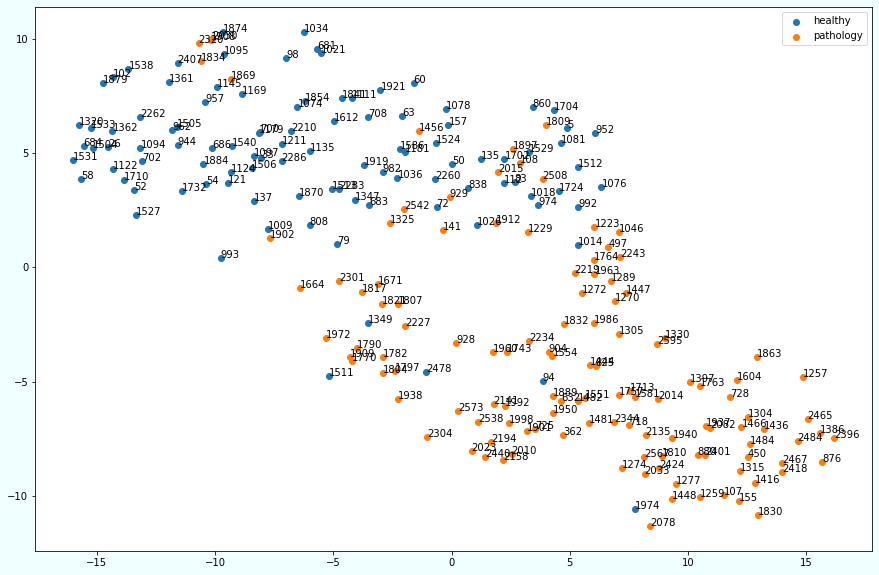

In [76]:

plt.figure(figsize=(15, 10), facecolor="azure")
for label in np.unique(labels_valid):
    points = valid_results_view[labels_valid==label]
    tmp = valid_results_view[labels_valid==label].tolist()
    path_name = np.array(path_list_valid)[labels_valid==label].tolist()
    plt.scatter(points[:, 0], points[:, 1],label=label)
    for idx,text in enumerate(path_name):
        plt.text(tmp[idx][0], tmp[idx][1],text)
    

plt.legend(['healthy','pathology'])
plt.show()

In [ ]:
np.array(train_results).shape

C:\Users\USER\AppData\Local\Temp/ipykernel_3168/563160018.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array(train_results).shape


(51,)

In [ ]:
train_results.shape

(812, 1000)

In [53]:
train_results.shape

(812, 2)

d:\anaconda3\envs\local_torch\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
d:\anaconda3\envs\local_torch\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


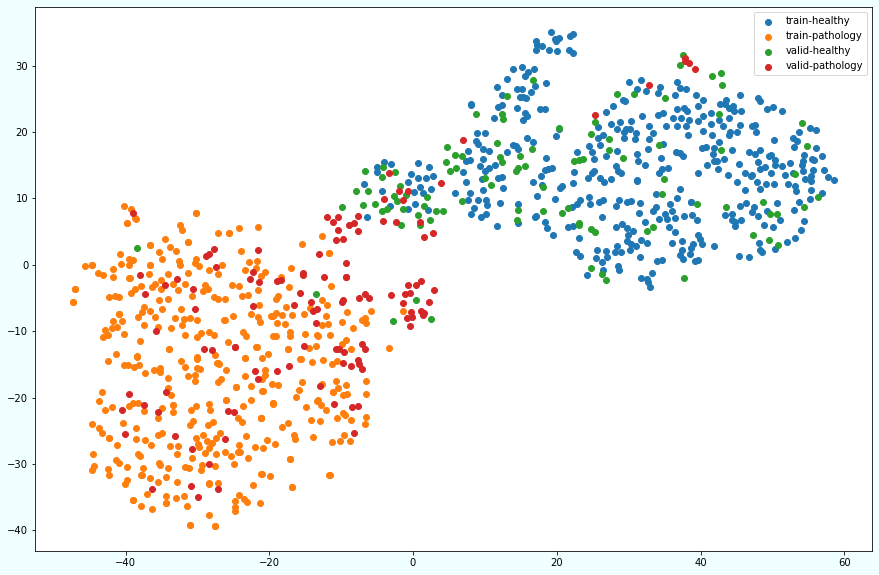

In [79]:
from sklearn.decomposition import PCA
# 동시에 그리기


# trainset

from sklearn.manifold import TSNE
from sklearn.datasets import load_digits

#which_epoch = 39

# MNIST 데이터 불러오기
#data = load_digits()

# 2차원으로 차원 축소
n_components = 2

# t-sne 모델 생성
tsne = TSNE(n_components=n_components)

# 학습한 결과 2차원 공간 값 출력
#print(tsne.fit_transform(train_results))
train_results_view=tsne.fit_transform(np.concatenate([train_results,valid_results],axis=0) ) 

train_len=len(train_results)
valid_len=len(valid_results)


# MNIST 데이터 불러오기
#data = load_digits()

# 2차원으로 차원 축소
n_components = 2

# t-sne 모델 생성
#tsne = TSNE(n_components=n_components)

# 학습한 결과 2차원 공간 값 출력
#print(tsne.fit_transform(train_results))
#valid_results_view=tsne.fit_transform(valid_result_list[which_epoch])
#valid_results_view=tsne.transform(valid_result_list[which_epoch])


plt.figure(figsize=(15, 10), facecolor="azure")

for label in np.unique(labels_train):
    tmp = train_results_view[:train_len][labels_train==label]
    path_name = np.array(path_list_train)[labels_train==label].tolist()
    plt.scatter(tmp[:, 0], tmp[:, 1],label=label)
    # for idx,text in enumerate(path_name):
    #     if idx % 3 ==0:
    #         plt.text(tmp[idx][0], tmp[idx][1],text)



for label in np.unique(labels_valid):
    # if label==0:
    #     continue
    points = train_results_view[train_len:][labels_valid==label]
    tmp = train_results_view[train_len:][labels_valid==label].tolist()
    path_name = np.array(path_list_valid)[labels_valid==label].tolist()
    #accs = np.array(valid_probs_list)[labels_valid==label].tolist()
    #accs = ["{:.2f}".format(acc) for  acc in accs]
    plt.scatter(points[:, 0], points[:, 1],label=label)
    # for idx,text in enumerate(accs):
    #     if label == 1:        
    #         plt.text(tmp[idx][0], tmp[idx][1],text)    
    # for idx,text in enumerate(path_name):
    #     if label == 1 :
    #     #if idx %3 ==0:
    #         #print(idx,text)
    #         plt.text(tmp[idx][0], tmp[idx][1],text)
    
name = "EGG_FUSION_"

plt.legend(['train-healthy','train-pathology','valid-healthy','valid-pathology'])
plt.savefig("./images/{}_{}fold_all.png".format(name,5))
plt.show()


# loss 시각화

In [ ]:
plt.plot(train_loss_list[0])
plt.plot(valid_loss_list[0])
plt.show()

In [ ]:
plt.plot(train_loss_list[1])
plt.plot(valid_loss_list[1])
plt.show()

In [ ]:
plt.plot(train_loss_list[2])
plt.plot(valid_loss_list[2])
plt.show()

In [ ]:
plt.plot(train_loss_list[3])
plt.plot(valid_loss_list[3])
plt.show()

In [ ]:
plt.plot(train_loss_list[4])
plt.plot(valid_loss_list[4])
plt.show()

In [ ]:
plt.plot(train_accs_list[0])
plt.plot(valid_accs_list[0])
plt.show()

In [ ]:
plt.plot(train_accs_list[1])
plt.plot(valid_accs_list[1])
plt.show()

In [ ]:
plt.plot(train_accs_list[2])
plt.plot(valid_accs_list[2])
plt.show()

In [ ]:
plt.plot(train_accs_list[3])
plt.plot(valid_accs_list[3])
plt.show()

In [ ]:
plt.plot(train_accs_list[4])
plt.plot(valid_accs_list[4])
plt.show()

# 결과 출력 -validation

In [ ]:
# 모델
# pretrained

class ResLayer(nn.Module):
    def __init__(self):
        super(ResLayer, self).__init__()
        self.model = models.resnet18(pretrained=True).cuda() 
        self.num_ftrs = self.model.fc.out_features
        
        
        
        self.fc = nn.Sequential(       
            nn.Linear(self.num_ftrs, 64),
                             nn.BatchNorm1d(64),
                             nn.ReLU(),
                             nn.Dropout(p=0.5),
                             nn.Linear(64,50),
                             nn.BatchNorm1d(50),
                             nn.ReLU(),
                             nn.Dropout(p=0.5),
                             nn.Linear(50,2)
                            )
        

    def forward(self, x):
        x = self.model(x)
        x  = self.fc(x)
        return x





def model_initialize():
    model = ResLayer().cuda()
    return model

model=model_initialize()

In [ ]:
#default param
mfcc_run_config = dict(
    sr=16000,
    n_mfcc=27,
    #dct_type=3, # type2 default
    lifter = 35,

    
    #mel spectro
    n_mels=170,
    hop_length=750,
    n_fft =14056,    
    win_length=1100,
    f_max=8000,
    
    # training
    #batch_size=32,
    mel_scale ='htk',
    
    # data
    fold=1,
)

mel_run_config = dict(
    sr=16000,
    n_mels=128,
    win_length =  300,
    n_fft= 2048,
    hop_length= 50,
    f_max = 8000    
)


spectro_run_config =dict(
    sr=16000,
    n_fft=350,
    hop_length=50,
    win_length=350,
    # training
    batch_size=16,
)




In [ ]:
from torch.utils.data import Dataset, DataLoader

classes = ["healthy","pathology"]


class svd_dataset_valid(Dataset):
    def __init__(self,data_path_list,classes,data_num,training,mfcc_params,mel_params,spectro_params,transform=None,normalize=None,mfcc_normalize=None):
        #클래스에서 사용할 인자를 받아 인스턴스 변수로 저장하는 일을 한다.
        #예를들면, 이미지의 경로 리스트를 저장하는 일을 하게 된다.
        
        #data_num : k 개 데이터 셋 중 어떤것을 쓸지
        #test인지 아닌지.
        
        self.path_list = data_path_list[data_num]
        self.data_num = data_num
        self.training = training
        self.label = svd_dataset_valid.get_label(self.path_list,training,data_num)
        self.classes=classes
        self.transform=transform
        self.normalize=normalize
        self.mfcc_normalize = mfcc_normalize
        # sweep params
        self.mel_params = mel_params
        self.spectro_params = spectro_params
        self.mfcc_params = mfcc_params
        #sr,n_mfcc,lifter, hop_length , win_length , n_mels , n_fft , f_max , batch_size

        
    
    @classmethod
    def get_label(cls,data_path_list,training,data_num):
        label_list=[]
        
        if training:
            for idx,x in enumerate(data_path_list):
                label_list.append(Y_train_list[data_num][idx])
        else:
            for idx,x in enumerate(data_path_list):
                label_list.append(Y_valid_list[data_num][idx])
        #print(label_list)
        return label_list
    
    
    def __len__(self):
        return len(self.path_list)
        #데이터 셋의 길이를 정수로 반환한다.     
    
       
    def __getitem__(self, idx):
        """
        1. path를 받아서, 소리에서 mfcc를 추출
        2. mfcc를 224프레임으로 패딩.
        3. resnet에 사용되기 위해 3채널로 복사(rgb 처럼)
        4. 0~1 정규화
        
        """
        sig = phrase_dict[ str(self.path_list[idx])+'-phrase.wav'] 
        #sig = preemphasis(sig)
        
        origin_length = sig.shape[0]
        
        if sig.shape[0] > self.mfcc_params["sr"]*2:
            origin_length = self.mfcc_params["sr"]*2
        
        origin_frame_size = 1 + int(np.floor(origin_length//self.mel_params["hop_length"]))
        
        length = self.mfcc_params["sr"]*2 #sample rate *2 padding을 위한 파라미터 (하이퍼 파라미터로인해 사이즈는 계속 바뀐다.)
        pad1d = lambda a, i: a[0:i] if a.shape[0] > i else np.hstack((a, np.zeros((i-a.shape[0]))))        
        sig = pad1d(sig,length)        
        
        ###signal norm
        sig = (sig-sig.mean())/sig.std()
        ###
        
        mel_feature = librosa.feature.melspectrogram(y=sig,
                                                     sr=self.mel_params["sr"],
                                                     # hyp param
                                                     n_mels = self.mel_params["n_mels"],
                                                     n_fft = self.mel_params["n_fft"],
                                                     win_length = self.mel_params["win_length"],
                                                     hop_length = self.mel_params["hop_length"],
                                                     fmax = self.mel_params["f_max"]
                                                    )
        mel_feature = librosa.core.power_to_db(mel_feature,ref=np.max) 
        
        
        if self.transform:
            mel_feature = self.transform(mel_feature).type(torch.float32)# 데이터 0~1 정규화
            MSF = torch.stack([mel_feature, mel_feature, mel_feature])# 3채널로 복사.
            MSF = MSF.squeeze(dim=1)    
            
            # global normalize
            if self.normalize:
                #MFCCs=self.normalize(MFCCs)
                MSF = self.normalize(MSF)
        else:
            pass
            #print("else")
            mel_feature = torch.from_numpy(mel_feature).type(torch.float32)
            mel_feature = mel_feature.unsqueeze(0)#cnn 사용위해서 추가
            #MFCCs = MFCCs.permute(2, 0, 1)
        return MSF, self.classes.index(self.label[idx]),str(self.path_list[idx])+'-phrase.wav'
    

In [ ]:

all_filename=[]
all_prediction=[]
all_answers=[]


def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)


def valid_evaluate(model,data_ind):

    model.eval()
    test_loss = 0
    predictions = []
    answers = []
    file_name = []
    
    criterion = nn.CrossEntropyLoss()
    BATCH_SIZE=16

    validation_loader = torch.utils.data.DataLoader(dataset = 
                                               svd_dataset_valid(
                                                   X_valid_list,
                                                   classes,
                                                   transform = transforms.ToTensor(),
                                                   data_num=data_ind,
                                                   #normalize=transforms.Normalize((-11.4805,-54.7723,-54.7723),(16.87,19.0226,19.0226)),
                                                   #mfcc_normalize=(53.5582, 217.43),
                                                   mfcc_params=mfcc_run_config,
                                                   mel_params=mel_run_config,
                                                   spectro_params=spectro_run_config,
                                                   training=False
                                               ),
                                                    batch_size = BATCH_SIZE,
                                                    shuffle = True,
                                                    worker_init_fn=seed_worker)    
    
    
    
    with torch.no_grad():
        for image,label,path_list in validation_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1,keepdim=True)[1] # 가장 확률이 높은 class 1개를 가져온다.그리고 인덱스만
            answers +=label
            predictions +=prediction
            file_name+=(path_list)
        all_filename.append(file_name)
        all_prediction.append(predictions)
        all_answers.append(answers)
    return predictions,answers,test_loss
            

In [ ]:
# Confusion matrix (resnet18)
# kfold의 confusion matrix는 계산 방법이 다르다.
# 모델을 각각 불러와서 test set을 평가한다.

from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

cf = np.zeros((2,2))
cf_list = []
average_accuracy = 0
average_fscore = 0
average_uar = 0

all_filename=[]
all_prediction=[]
all_answers=[]

args={  'model':'baseline',
        'seed':1004
        }





for data_ind in range(1,6):
    model=model_initialize()
    check_path = './checkpoint/checkpoint_ros_fold_'+str(data_ind)+'_'+args['model']+'_seed_'+str(args['seed'])+'_organics_speaker.pt'
    model.load_state_dict(torch.load(check_path))

    predictions,answers,valid_loss = valid_evaluate(model, data_ind-1)
    predictions=[ dat.cpu().numpy() for dat in predictions]
    answers=[ dat.cpu().numpy() for dat in answers]

    
    cf = confusion_matrix(answers, predictions)
    cf_list.append(cf)
    
    acc = (cf[0,0]+cf[1,1])/(cf[0,0]+cf[0,1]+cf[1,0]+cf[1,1])
    average_accuracy+=acc
    
    precision=cf[1,1]/(cf[0,1]+cf[1,1])
    
    recall=cf[1,1]/(cf[1,1]+cf[1,0])
    
    specificity=cf[0,0]/(cf[0,0]+cf[0,1])
    average_uar += (specificity+recall)/2
    
    #fscroe macro추가
    fscore = f1_score(answers,predictions,average='macro')
    average_fscore+=fscore
    
    print('{}번 모델'.format(data_ind))
    print("Accuracy : {:.4f}% ".format(acc*100))
    print("Precision (pathology 예측한 것중 맞는 것) : {:.4f}".format(precision))
    print("recall (실제 pathology 중  예측이 맞는 것) : {:.4f}".format(recall))
    print("specificity : {:.4f}%".format(specificity))
    print("UAR : {:.4f}%".format( (specificity+recall)/2 ))
    
    
    print("f score : {:.4f} ".format(fscore))
    print(cf)
    print("-----")
    
    
    

print("평균 acc : {:.4f}".format(average_accuracy/5))
print("평균 UAR : {:.4f}".format(average_uar/5))
print("평균 f1score : {:.4f}".format(average_fscore/5))




1번 모델
Accuracy : 84.8624% 
Precision (pathology 예측한 것중 맞는 것) : 0.8636
recall (실제 pathology 중  예측이 맞는 것) : 0.8407
specificity : 0.8571%
UAR : 0.8489%
f score : 0.8485 
[[90 15]
 [18 95]]
-----
2번 모델
Accuracy : 87.8505% 
Precision (pathology 예측한 것중 맞는 것) : 0.8707
recall (실제 pathology 중  예측이 맞는 것) : 0.9018
specificity : 0.8529%
UAR : 0.8774%
f score : 0.8780 
[[ 87  15]
 [ 11 101]]
-----
3번 모델
Accuracy : 86.1702% 
Precision (pathology 예측한 것중 맞는 것) : 0.8488
recall (실제 pathology 중  예측이 맞는 것) : 0.8488
specificity : 0.8725%
UAR : 0.8607%
f score : 0.8607 
[[89 13]
 [13 73]]
-----
4번 모델
Accuracy : 88.8889% 
Precision (pathology 예측한 것중 맞는 것) : 0.8642
recall (실제 pathology 중  예측이 맞는 것) : 0.8861
specificity : 0.8911%
UAR : 0.8886%
f score : 0.8875 
[[90 11]
 [ 9 70]]
-----
5번 모델
Accuracy : 92.3858% 
Precision (pathology 예측한 것중 맞는 것) : 0.9263
recall (실제 pathology 중  예측이 맞는 것) : 0.9167
specificity : 0.9307%
UAR : 0.9237%
f score : 0.9238 
[[94  7]
 [ 8 88]]
-----
평균 acc : 0.8803
평균 UAR : 0.8798
평균 f

In [ ]:
len(all_filename)

5

In [ ]:
fold_excel = []
for i in range(5):
    fold_excel.append(pd.DataFrame({'filename':all_filename[i],
                  'prediction':[data.cpu().numpy().item() for data in all_prediction[i]],
                  'answer':[ data.cpu().numpy().item() for data in all_answers[i]],
                  'fold':i+1}))

In [ ]:
fold_excel_all=pd.concat(fold_excel,axis=0)

In [ ]:
answer_paper=pd.read_excel('D:/project/voice_pathology_ai/voice_data/only_organics_healthy.xlsx')
answer_paper.head()

,RECORDING,PATHOLOGY,DATE,SPEAKER,GENDER,AGE,DETAIL,DIAG
0,715,p,20.05.1998,1407,w,63,Laryngitis; Leukoplakie,structural
1,1303,p,21.04.1999,1407,w,64,Leukoplakie,structural
2,1557,p,08.12.1999,1407,w,65,Leukoplakie,structural
3,1559,p,15.12.1999,1407,w,65,Leukoplakie,structural
4,1864,p,29.11.2000,1407,w,66,Leukoplakie,structural


In [ ]:
answer_paper['RECORDING']=answer_paper['RECORDING'].values.astype(str)

In [ ]:
answer_paper['RECORDING']=answer_paper['RECORDING']+'-phrase.wav'

In [ ]:
answer_paper[['RECORDING','DETAIL','AGE']]

,RECORDING,DETAIL,AGE
0,715-phrase.wav,Laryngitis; Leukoplakie,63
1,1303-phrase.wav,Leukoplakie,64
2,1557-phrase.wav,Leukoplakie,65
3,1559-phrase.wav,Leukoplakie,65
4,1864-phrase.wav,Leukoplakie,66
...,...,...,...
1461,80-phrase.wav,control,49
1462,81-phrase.wav,control,42
1463,82-phrase.wav,control,49
1464,83-phrase.wav,control,46


In [ ]:
merge_left = pd.merge(fold_excel_all,answer_paper[['RECORDING','DETAIL','AGE']], how='left', left_on='filename', right_on='RECORDING')
merge_left

,filename,prediction,answer,fold,RECORDING,DETAIL,AGE
0,946-phrase.wav,0,0,1,946-phrase.wav,control,37
1,94-phrase.wav,1,0,1,94-phrase.wav,control,55
2,876-phrase.wav,1,1,1,876-phrase.wav,Diplophonie; Kontaktpachydermie,73
3,1181-phrase.wav,0,0,1,1181-phrase.wav,control,32
4,2028-phrase.wav,1,1,1,2028-phrase.wav,Dysphonie; Laryngitis,36
...,...,...,...,...,...,...,...
992,1967-phrase.wav,1,1,5,1967-phrase.wav,Kontaktpachydermie,60
993,21-phrase.wav,0,0,5,21-phrase.wav,control,20
994,2498-phrase.wav,0,1,5,2498-phrase.wav,Kontaktpachydermie,29
995,2375-phrase.wav,1,1,5,2375-phrase.wav,Reinke ?em,52


In [ ]:
merge_left.drop(['RECORDING'],axis=1,inplace=True)

In [ ]:
merge_left['result']=merge_left['prediction']==merge_left['answer']

In [ ]:
merge_left

,filename,prediction,answer,fold,DETAIL,AGE,result
0,946-phrase.wav,0,0,1,control,37,True
1,94-phrase.wav,1,0,1,control,55,False
2,876-phrase.wav,1,1,1,Diplophonie; Kontaktpachydermie,73,True
3,1181-phrase.wav,0,0,1,control,32,True
4,2028-phrase.wav,1,1,1,Dysphonie; Laryngitis,36,True
...,...,...,...,...,...,...,...
992,1967-phrase.wav,1,1,5,Kontaktpachydermie,60,True
993,21-phrase.wav,0,0,5,control,20,True
994,2498-phrase.wav,0,1,5,Kontaktpachydermie,29,False
995,2375-phrase.wav,1,1,5,Reinke ?em,52,True


In [ ]:
excel_name = 'D:/project/voice_pathology_ai/voice_data/'+args['model']+'_seed_'+str(args['seed'])+'_organics_speaker.xlsx'
merge_left.to_excel(excel_name,index=False)